<a href="https://colab.research.google.com/github/lukrak2002/projekt/blob/main/projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predykcja Cen Nieruchomości**

Współtwórcy - Jakub Majzoub, Yelyzaveta Merliuk, Łukasz Rakoczy

#Cześć I


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [2]:
file_path = "NY-House-Dataset.csv"

try:
    df = pd.read_csv(file_path, delimiter=",", quoting=3, on_bad_lines='skip')
    print("Plik wczytany poprawnie.")
except pd.errors.ParserError as e:
    print(f"Błąd parsowania CSV: {e}")
    line_number = int(str(e).split("line ")[1].split(",")[0])

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i == line_number - 1:
                print(f"Problematic line {line_number}: {line.strip()}")
                break


    try:
        df = pd.read_csv(file_path, delimiter=";")
        print("Plik wczytany poprawnie z separatorem ';'.")
    except Exception as e:
        print(f"Nie udało się wczytać pliku nawet z innym separatorem: {e}")

# Wyświetl pierwsze 5 wierszy dla sprawdzenia
print(df.head())

Plik wczytany poprawnie.
                                                                                                                                                                                                              BROKERTITLE;TYPE;PRICE;BEDS;BATH;PROPERTYSQFT;ADDRESS;STATE;MAIN_ADDRESS;ADMINISTRATIVE_AREA_LEVEL_2;LOCALITY;SUBLOCALITY;STREET_NAME;LONG_NAME;FORMATTED_ADDRESS;LATITUDE;LONGITUDE
Brokered by Douglas Elliman  -111 Fifth Ave;Con... NY 10022;2 E 55th St Unit 803New York              NY 10022;New York County;New York;Manhattan;Eas... 2 E 55th St #803 New York NY 10022                                            USA;40.761255;-73.9744834                                                                                                                                  
Brokered by Serhant;Condo for sale;195000000;7;... NY 10019;Central Park Tower Penthouse-217 W 57t... NY 10019;United States;New York;New York County... New York         NY 10019 USA;40.7663935;-73.980

In [3]:
df.shape

(4783, 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4783 entries, ('Brokered by Douglas Elliman  -111 Fifth Ave;Condo for sale;315000;2;2;1400;2 E 55th St Unit 803;New York', ' NY 10022;2 E 55th St Unit 803New York', ' NY 10022;New York County;New York;Manhattan;East 55th Street;Regis Residence;Regis Residence', ' 2 E 55th St #803', ' New York', ' NY 10022') to ('Brokered by Nyc Realty Brokers Llc;Co-op for sale;349000;1;1;750;460 Neptune Ave Apt 14O;Brooklyn', ' NY 11224;460 Neptune Ave Apt 14OBrooklyn', ' NY 11224;New York;Kings County;Brooklyn;Coney Island;460;460 Neptune Ave #14a', ' Brooklyn', ' NY 11224', ' USA;40.579147;-73.9709488')
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                Non-Null Count  Dtype 
---  ------                                                                                                    

In [5]:
df = pd.read_csv(file_path, sep=';')

df.columns = df.columns.str.lower()
df.drop_duplicates(inplace=True)

columns_to_drop = [
    'address',
    'state',
    'main_address',
    'administrative_area_level_2',
    'locality',
    'street_name',
    'long_name',
    'latitude',
    'longitude'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


df.to_csv('przetworzony_plik.csv', index=False)

print(df.shape)
print(df.columns)
#print(df.head(100))

(4587, 8)
Index(['brokertitle', 'type', 'price', 'beds', 'bath', 'propertysqft',
       'sublocality', 'formatted_address'],
      dtype='object')


In [6]:
# sort

df_sorted = df.sort_values(by='price')
#print(df_sorted.head(100))


In [7]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip('_')
        df[col] = df[col].str.strip('-')
        df[col] = df[col].replace(' ', np.nan)
df.info()
#print(df.head(100))

<class 'pandas.core.frame.DataFrame'>
Index: 4587 entries, 0 to 4800
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brokertitle        4587 non-null   object 
 1   type               4587 non-null   object 
 2   price              4587 non-null   int64  
 3   beds               4587 non-null   int64  
 4   bath               4587 non-null   float64
 5   propertysqft       4587 non-null   float64
 6   sublocality        4587 non-null   object 
 7   formatted_address  4587 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 322.5+ KB


In [8]:
for col in ['bath', 'propertysqft']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['bath'] = df['bath'].astype(str).str.rstrip('0').str.rstrip('.')
df['propertysqft'] = df['propertysqft'].astype(str).str.rstrip('0').str.rstrip('.')

df['price'] = df['price'].astype(str)

#print(df.head(100))

In [9]:
#print(df.head(500))

In [10]:
df['type'] = df['type'].str.replace('for sale', '', regex=False)

In [11]:
#print(df.head(100))

In [12]:
# prompt: usuń kolumny brokertitle i formatted_address

columns_to_drop = ['brokertitle', 'formatted_address','address']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


In [13]:
le_type = LabelEncoder()
le_sublocality = LabelEncoder()

df['type'] = le_type.fit_transform(df['type'])
df['sublocality'] = le_sublocality.fit_transform(df['sublocality'])

for class_label, original_value in enumerate(le_type.classes_):
    print(f"Type: {class_label} represents: {original_value}")
for class_label, original_value in enumerate(le_sublocality.classes_):
    print(f"Sublocality: {class_label} represents: {original_value}")

Type: 0 represents: Co-op 
Type: 1 represents: Coming Soon
Type: 2 represents: Condo 
Type: 3 represents: Condop 
Type: 4 represents: Contingent
Type: 5 represents: For sale
Type: 6 represents: Foreclosure
Type: 7 represents: House 
Type: 8 represents: Land 
Type: 9 represents: Mobile house 
Type: 10 represents: Multi-family home 
Type: 11 represents: Pending
Type: 12 represents: Townhouse 
Sublocality: 0 represents: Bronx County
Sublocality: 1 represents: Brooklyn
Sublocality: 2 represents: Brooklyn Heights
Sublocality: 3 represents: Coney Island
Sublocality: 4 represents: Dumbo
Sublocality: 5 represents: East Bronx
Sublocality: 6 represents: Flushing
Sublocality: 7 represents: Fort Hamilton
Sublocality: 8 represents: Jackson Heights
Sublocality: 9 represents: Kings County
Sublocality: 10 represents: Manhattan
Sublocality: 11 represents: New York
Sublocality: 12 represents: New York County
Sublocality: 13 represents: Queens
Sublocality: 14 represents: Queens County
Sublocality: 15 rep

In [14]:
#print(df.head(100))

In [15]:
df_sorted = df.sort_values(by='price')
#print(df_sorted.head(4000))

In [16]:
#df.dtypes

##All int64

In [17]:
# for col in df.columns:
#     try:
#         # Attempt to convert the column to numeric first.  This handles
#         # cases where the column contains strings that can be converted
#         # to numbers (e.g., "123", "123.0").
#         df[col] = pd.to_numeric(df_sorted[col])

#         #Then convert column to int
#         df[col] = df[col].astype(np.int64)
#     except (ValueError, TypeError):
#         print(f"Column '{col}' cannot be converted to int64. Dropping rows with non-convertible values.")
#         #Drop rows where conversion to int64 fails
#         df = df[pd.to_numeric(df[col], errors='coerce').notna()]
#         df[col] = df[col].astype(np.int64)

In [18]:
df.head()

,type,price,beds,bath,propertysqft,sublocality
0,2,315000,2,2,1400,10
1,2,195000000,7,10,17545,12
2,7,260000,4,2,2015,16
3,2,69000,3,1,445,12
4,12,55000000,7,2.3738608579684373,14175,12


##Old Outliers handling v0

In [19]:
# df['price'] = pd.to_numeric(df['price'], errors='coerce')

# plt.figure(figsize=(10, 6))
# sns.boxplot(y='price', data=df)

# # Calculate outlier boundaries
# Q1 = df['price'].quantile(0.25)
# Q3 = df['price'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Add red lines for outlier boundaries
# plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
# plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')

# plt.title('Boxplot of Price with Outlier Boundaries')
# plt.ylabel('Price')
# plt.legend()
# plt.show()


In [20]:
# # Zastąpienie wartości odstających w 'price' średnią
# mean_price = df['price'][(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].mean()
# df.loc[(df['price'] < lower_bound) | (df['price'] > upper_bound), 'price'] = mean_price

# # Wykres po usunięciu wartości odstających
# plt.figure(figsize=(8, 6))
# plt.plot(df['price'], marker='o', linestyle='')
# plt.xlabel('Index')
# plt.ylabel('Price')
# plt.title('Price after Outlier Replacement')
# plt.show()

In [21]:
# plt.figure(figsize=(10, 6))
# sns.boxplot(y='price', data=df)

# # Calculate outlier boundaries
# Q1 = df['price'].quantile(0.25)
# Q3 = df['price'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Add red lines for outlier boundaries
# plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
# plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')

# plt.title('Boxplot of Price with Outlier Boundaries')
# plt.ylabel('Price')
# plt.legend()
# plt.show()

##Deleting outliers

wykres wygląda lepiej po usunięciu ale rośnie MSE MAE  i maleje R^2 i EVS

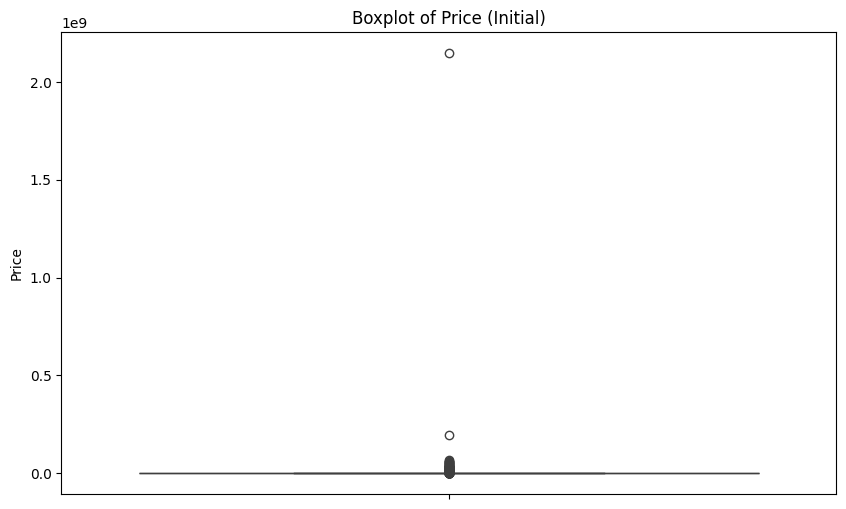

Lower threshold (2.5%): 185000.00
Upper threshold (90.5%): 3649330.00
Original DataFrame shape: (4587, 6)
Trimmed DataFrame shape: (4039, 6)


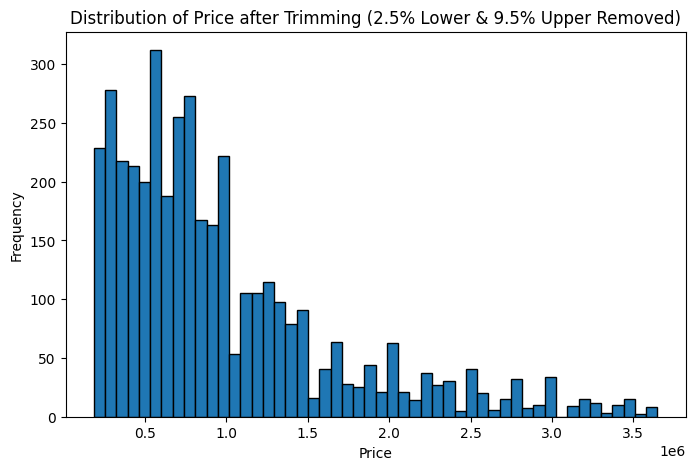

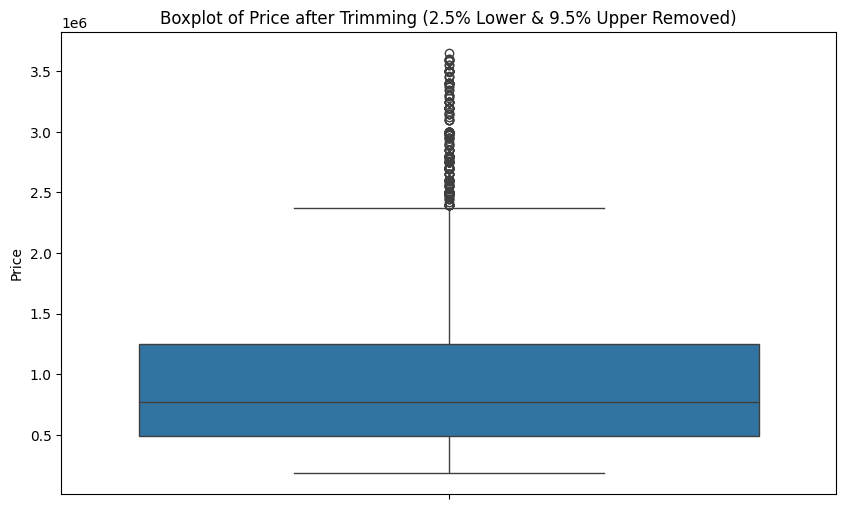

In [22]:
# Assuming your DataFrame 'df' is already loaded

# Convert 'price' to numeric, coercing errors to NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# --- Initial Boxplot of Price ---
plt.figure(figsize=(10, 6))
sns.boxplot(y='price', data=df)
plt.title('Boxplot of Price (Initial)')
plt.ylabel('Price')
plt.show()

# --- Calculate the percentiles for trimming ---
lower_percentile = 0.025
upper_percentile = 0.905

lower_threshold = df['price'].quantile(lower_percentile)
upper_threshold = df['price'].quantile(upper_percentile)

print(f"Lower threshold (2.5%): {lower_threshold:.2f}")
print(f"Upper threshold (90.5%): {upper_threshold:.2f}")

# --- Remove data outside the calculated thresholds ---
df_trimmed = df[(df['price'] >= lower_threshold) & (df['price'] <= upper_threshold)].copy()

print(f"Original DataFrame shape: {df.shape}")
print(f"Trimmed DataFrame shape: {df_trimmed.shape}")

# --- Plot of Price after Trimming ---
plt.figure(figsize=(8, 5))
plt.hist(df_trimmed['price'], bins=50, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price after Trimming (2.5% Lower & 9.5% Upper Removed)')
plt.show()

# --- Boxplot of Price after Trimming ---
plt.figure(figsize=(10, 6))
sns.boxplot(y='price', data=df_trimmed)
plt.title('Boxplot of Price after Trimming (2.5% Lower & 9.5% Upper Removed)')
plt.ylabel('Price')
plt.show()

df = df_trimmed

##New outliers handling v1

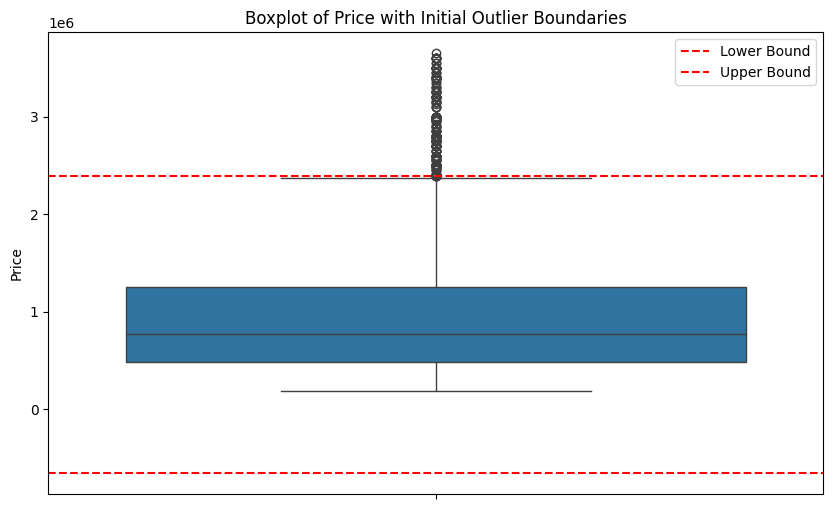

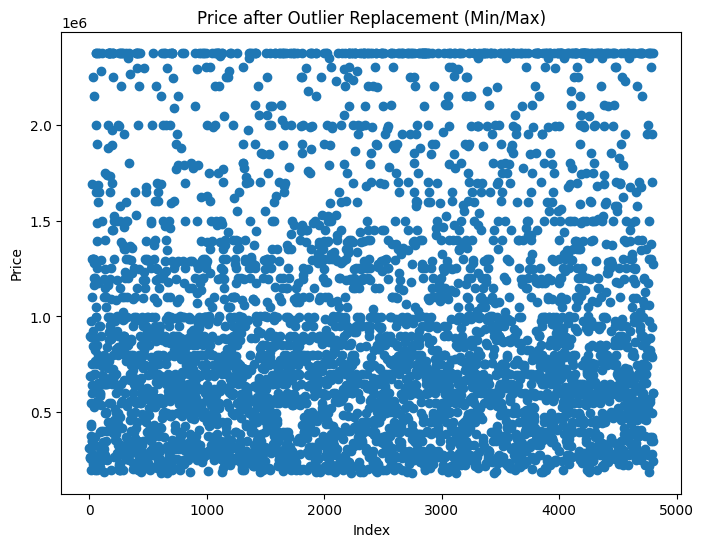

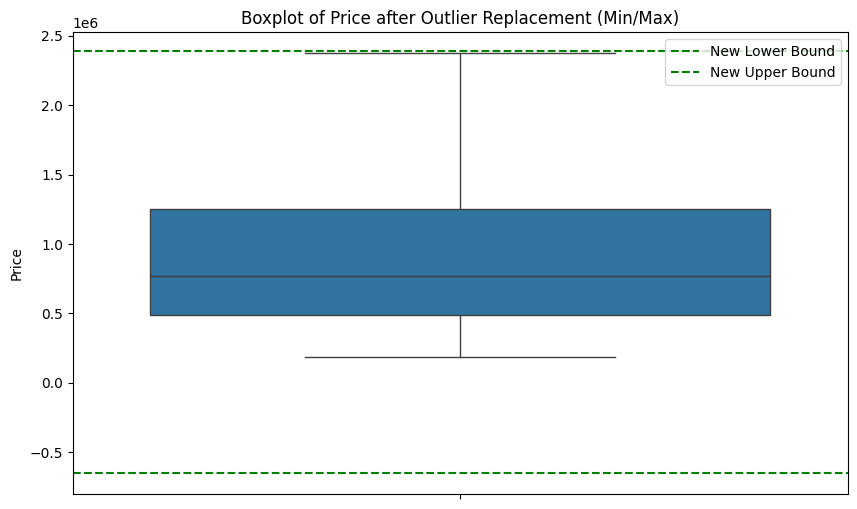

In [23]:
# Assuming your DataFrame 'df' is already loaded

# Convert 'price' to numeric, coercing errors to NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# --- Initial Boxplot with Outlier Boundaries ---
plt.figure(figsize=(10, 6))
sns.boxplot(y='price', data=df)

# Calculate initial outlier boundaries
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add red lines for outlier boundaries
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')

plt.title('Boxplot of Price with Initial Outlier Boundaries')
plt.ylabel('Price')
plt.legend()
plt.show()

# --- Replacing Outliers with Min/Max Non-Outlier Values ---

# Identify non-outlier values
non_outliers = df['price'][(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Calculate the minimum and maximum of the non-outlier prices
min_non_outlier_price = non_outliers.min()
max_non_outlier_price = non_outliers.max()

# Replace lower outliers with the minimum non-outlier price
df.loc[df['price'] < lower_bound, 'price'] = min_non_outlier_price

# Replace upper outliers with the maximum non-outlier price
df.loc[df['price'] > upper_bound, 'price'] = max_non_outlier_price

# --- Plot after Outlier Replacement ---
plt.figure(figsize=(8, 6))
plt.plot(df['price'], marker='o', linestyle='')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Price after Outlier Replacement (Min/Max)')
plt.show()

# --- Boxplot after Outlier Replacement ---
plt.figure(figsize=(10, 6))
sns.boxplot(y='price', data=df)

# Recalculate outlier boundaries based on the modified data (optional, for visualization)
Q1_new = df['price'].quantile(0.25)
Q3_new = df['price'].quantile(0.75)
IQR_new = Q3_new - Q1_new
lower_bound_new = Q1_new - 1.5 * IQR_new
upper_bound_new = Q3_new + 1.5 * IQR_new

# Add red lines for the new outlier boundaries (optional)
plt.axhline(y=lower_bound_new, color='g', linestyle='--', label='New Lower Bound')
plt.axhline(y=upper_bound_new, color='g', linestyle='--', label='New Upper Bound')

plt.title('Boxplot of Price after Outlier Replacement (Min/Max)')
plt.ylabel('Price')
plt.legend()
plt.show()

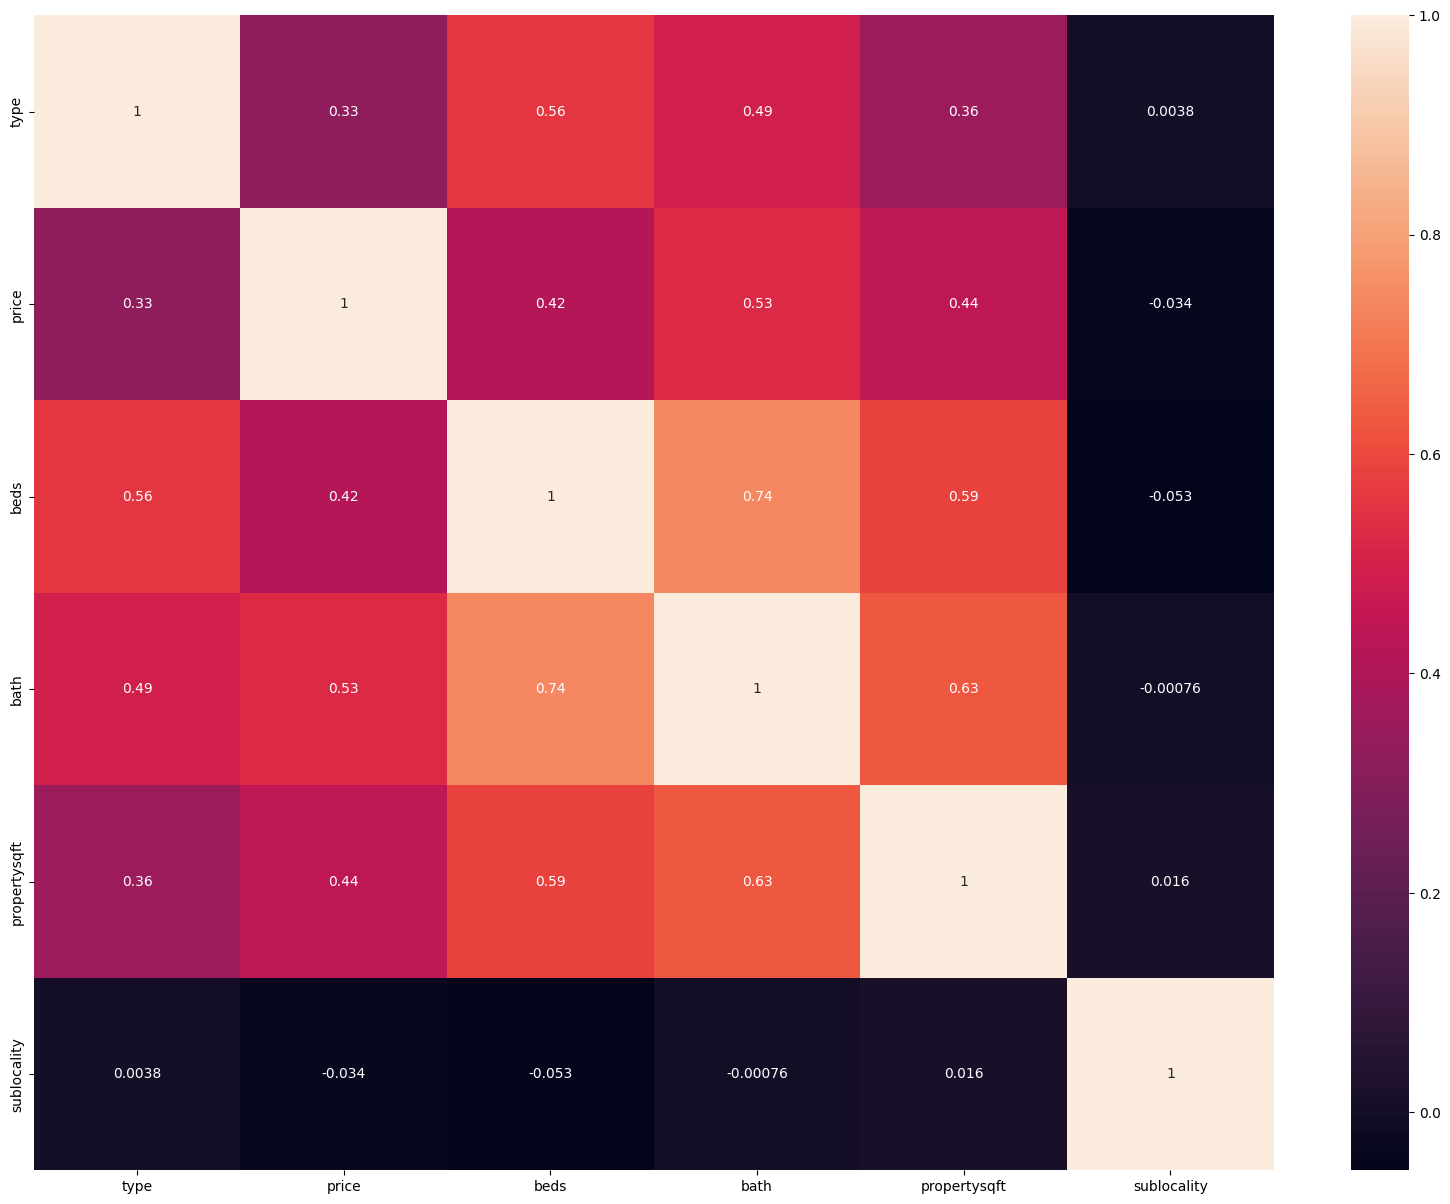

In [24]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

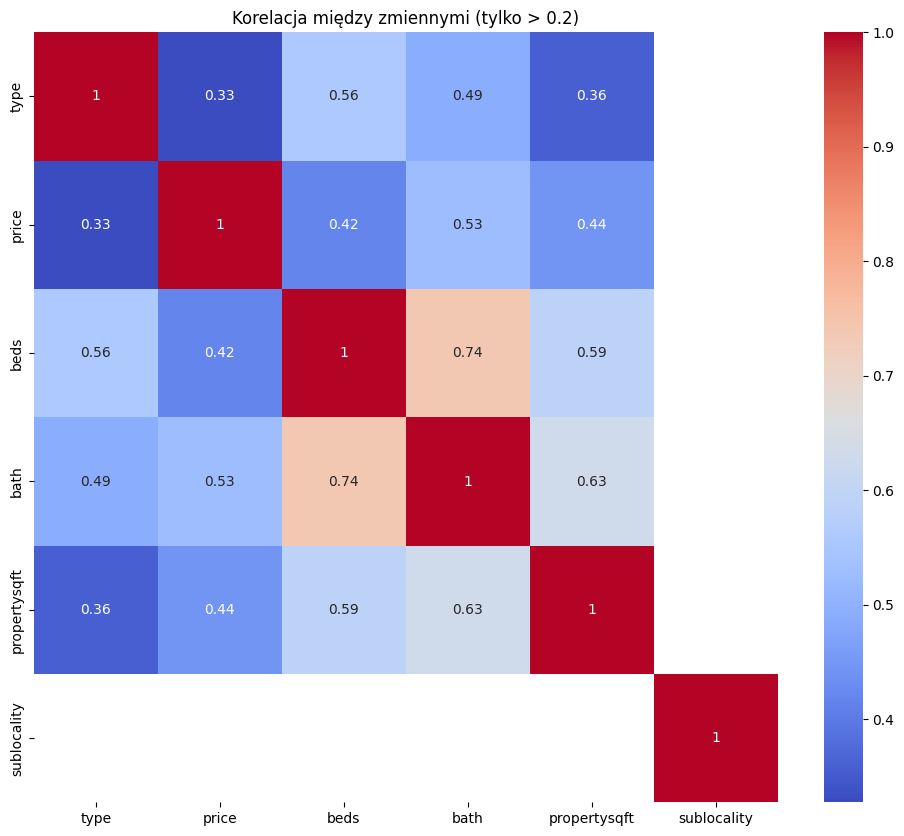

In [25]:
#Pokaz korelacje między zmiennymi tylko jesli są większe od 0.2
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[abs(corr_matrix) > 0.2], annot=True, cmap='coolwarm')
plt.title('Korelacja między zmiennymi (tylko > 0.2)')
plt.show()

#Część II

Model podstawowy jako wybrany benchmark, wybranie metod oceny modelu, wyznaczenie danych uczących i testowych

In [26]:
df.dtypes

,0
type,int64
price,int64
beds,int64
bath,object
propertysqft,object
sublocality,int64


**Model podstawowy**

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [28]:
#df.columns

In [29]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

train and test data

In [30]:
# Separate features (X) and target (y)
X = df.drop('price', axis=1)
y = df['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##RobustScaler and MinMax


In [31]:
# from sklearn.preprocessing import MinMaxScaler, RobustScaler

# robust_scaler = RobustScaler()

# # Fit the scaler on the training data and then transform it
# X_train_robust = robust_scaler.fit_transform(X_train)
# X_test_robust = robust_scaler.transform(X_test)

# min_max_scaler = MinMaxScaler()

# # Fit the scaler on the training data and then transform it
# X_train_minmax = min_max_scaler.fit_transform(X_train)
# X_test_minmax = min_max_scaler.transform(X_test)

##StandardScaler

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


--- Polynomial Regression (Degree 3) ---
Średni błąd kwadratowy (MSE): 181446896118.62
Średni błąd absolutny (MAE): 306756.09
Wynik wyjaśnionej wariancji (EVS): 0.52
Współczynnik determinacji (R^2): 0.52


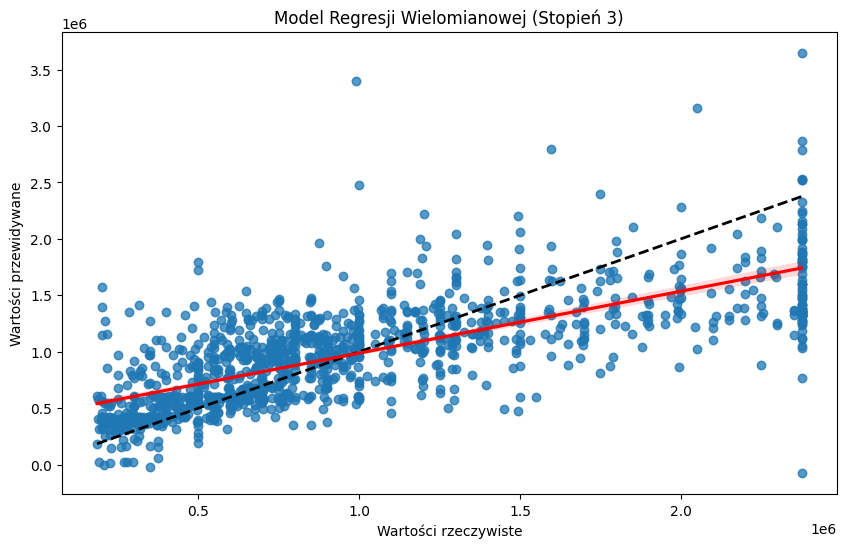

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)

print("\n--- Polynomial Regression (Degree 3) ---")
mse_poly = mean_squared_error(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
evs_poly = explained_variance_score(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Średni błąd kwadratowy (MSE): {mse_poly:.2f}")
print(f"Średni błąd absolutny (MAE): {mae_poly:.2f}")
print(f"Wynik wyjaśnionej wariancji (EVS): {evs_poly:.2f}")
print(f"Współczynnik determinacji (R^2): {r2_poly:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
sns.regplot(x=y_test, y=y_pred_poly, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Wartości przewidywane')
plt.title('Model Regresji Wielomianowej (Stopień 3)')
plt.show()

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X['bath'] = pd.to_numeric(X['bath'], errors='coerce')
X['propertysqft'] = pd.to_numeric(X['propertysqft'], errors='coerce')

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,type,3.361490
1,beds,7.782712
2,bath,8.095115
3,propertysqft,6.215570
4,sublocality,2.613813


#Cześć III

Model osiąga wyższy R dla Random Forest

##Linear

--- Linear Regression ---
Średni błąd kwadratowy (MSE): 275351854006.40
Średni błąd absolutny (MAE): 390767.61
Współczynnik determinacji (R^2): 0.27


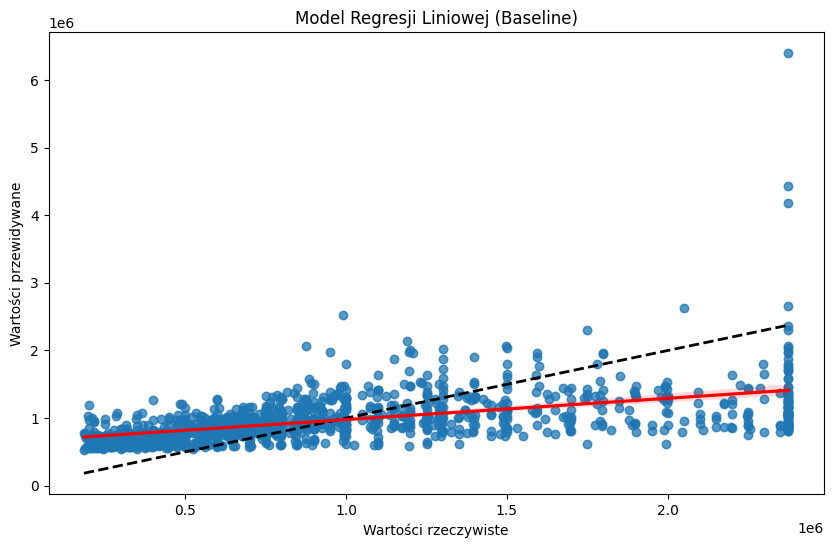

In [41]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)
y_pred_linear = linear_reg.predict(X_test_scaled)

print("--- Linear Regression ---")
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Średni błąd kwadratowy (MSE): {mse_linear:.2f}")
print(f"Średni błąd absolutny (MAE): {mae_linear:.2f}")
print(f"Współczynnik determinacji (R^2): {r2_linear:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
sns.regplot(x=y_test, y=y_pred_linear, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Wartości przewidywane')
plt.title('Model Regresji Liniowej (Baseline)')
plt.show()

##Random Forest



RandomForestRegressor Results:
Średni błąd kwadratowy (MSE): 151597519208.41
Średni błąd absolutny (MAE): 268893.57
Wynik wyjaśnionej wariancji (EVS): 0.60
Współczynnik determinacji (R-squared): 0.60


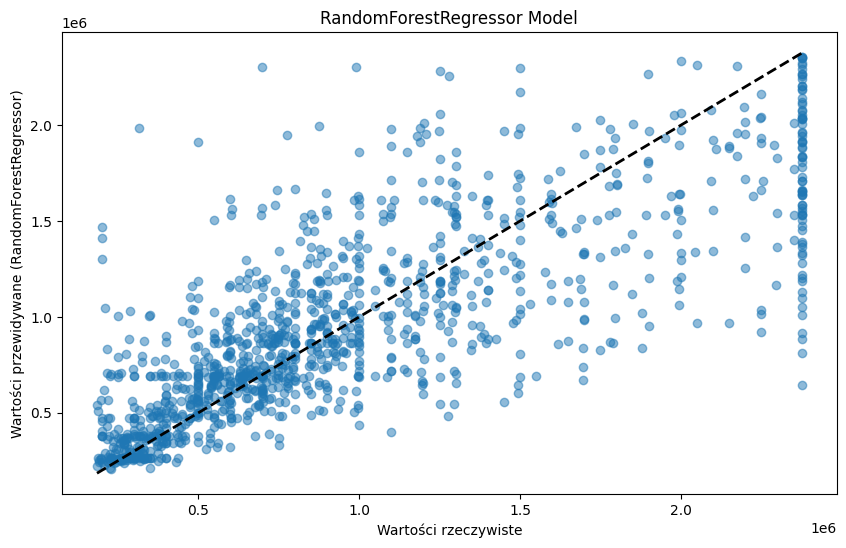

In [36]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred_rf = rf_regressor.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
evs_rf = explained_variance_score(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandomForestRegressor Results:")
print(f"Średni błąd kwadratowy (MSE): {mse_rf:.2f}")
print(f"Średni błąd absolutny (MAE): {mae_rf:.2f}")
print(f"Wynik wyjaśnionej wariancji (EVS): {evs_rf:.2f}")
print(f"Współczynnik determinacji (R-squared): {r2_rf:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Wartości przewidywane (RandomForestRegressor)')
plt.title('RandomForestRegressor Model')
plt.show()


##KNeighbors


KNeighborsRegressor Results:
Średni błąd kwadratowy (MSE): 229953862823.14
Średni błąd absolutny (MAE): 347668.64
Wynik wyjaśnionej wariancji (EVS): 0.39


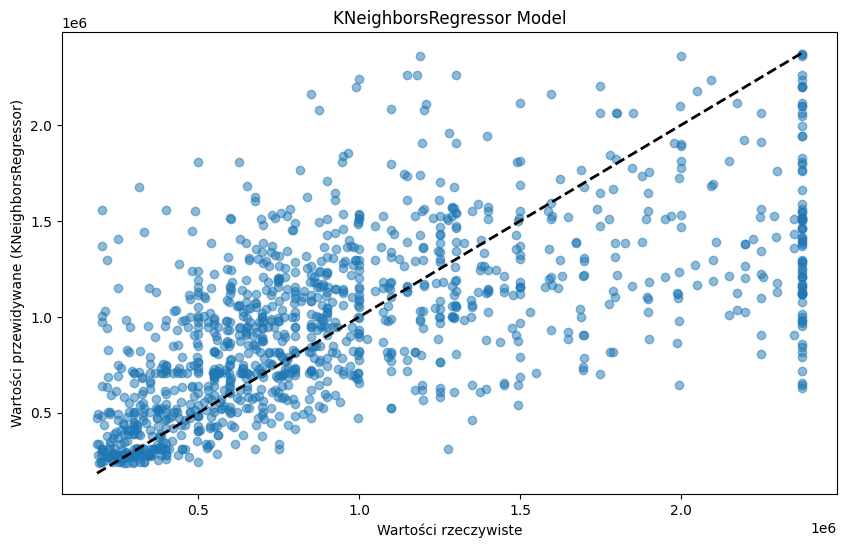

In [39]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)

y_pred_knn = knn_regressor.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
evs_knn = explained_variance_score(y_test, y_pred_knn)

print("\nKNeighborsRegressor Results:")
print(f"Średni błąd kwadratowy (MSE): {mse_knn:.2f}")
print(f"Średni błąd absolutny (MAE): {mae_knn:.2f}")
print(f"Wynik wyjaśnionej wariancji (EVS): {evs_knn:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Wartości przewidywane (KNeighborsRegressor)')
plt.title('KNeighborsRegressor Model')
plt.show()
